# Failure Prediction on Azure Telemetry Data Set

In [1]:
# Enable autoreloading
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import pandas as pd
import seaborn as sns
import string

from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import (f1_score,
                             make_scorer,
                             recall_score,
                             precision_recall_curve,
                             precision_score)
from sklearn.model_selection import (GroupKFold,
                                     RandomizedSearchCV,
                                     train_test_split)
from tqdm import tqdm
from urllib.parse import urljoin
from urllib.request import urlopen
from xgboost import XGBClassifier

from pmlib.data_transformation import split_data
from pmlib.evaluation.classical import auprg_score
from pmlib.evaluation.event_based import (f1_reduced_score,
                                          precision_reduced_score,
                                          recall_reduced_score)
from pmlib.evaluation.utils import series_scorer
from pmlib.feature_extraction import (create_features_last_event_time,
                                      prepare_events_data, unstack)
from pmlib.modeling import PredictiveMaintenanceModel
from pmlib.preprocessing import create_series_id, filter_short_series

In [3]:
N_JOBS = 32
RANDOM_STATE = 7

In [ ]:
!mkdir -p ./data/azure/
!mkdir -p ./images/azure/

# Load Data

In [10]:
BASE_URL = 'https://azuremlsampleexperiments.blob.core.windows.net/datasets/'
DATA_DIR = Path('./data/azure')

In [6]:
def load_azure_pdm_data_set():

    def _download_azure_data_set_file(file_name):
        try:
            df = pd.read_csv(DATA_DIR / file_name)
        except:
            with urlopen(urljoin(BASE_URL, file_name)) as f:
                df = pd.read_csv(f)
            df.to_csv(DATA_DIR / file_name, index=False)
        if 'datetime' in df.columns:
            df['datetime'] = pd.to_datetime(df['datetime'])
        return df
    
    telemetry = _download_azure_data_set_file('PdM_telemetry.csv')
    errors = _download_azure_data_set_file('PdM_errors.csv')
    machines = _download_azure_data_set_file('PdM_machines.csv')
    failures = _download_azure_data_set_file('PdM_failures.csv')
    maintenance = _download_azure_data_set_file('PdM_maint.csv')
    return telemetry, errors, machines, failures, maintenance

In [11]:
telemetry, errors, machines, failures, maintenance = load_azure_pdm_data_set()

# Preprocess Data

In [13]:
subject_id_col = 'machineID'
time_col = 'datetime'

## Preprocess and Merge Data Sources

### Telemetry Data

In [14]:
telemetry_preprocessed = telemetry.set_index([subject_id_col, time_col]).add_prefix('telemetry_raw_').reset_index()
feature_cols_telemetry = telemetry.columns[telemetry.columns.str.startswith('telemetry_raw')]

In [15]:
base_df = (
    telemetry[[subject_id_col, time_col]]
    .sort_values([subject_id_col, time_col])
    .reset_index(drop=True)
)

base_df.sample(5, random_state=RANDOM_STATE)

,machineID,datetime
656252,75,2015-11-28 00:00:00
749474,86,2015-07-19 19:00:00
722728,83,2015-06-30 12:00:00
434639,50,2015-08-12 04:00:00
50249,6,2015-09-26 18:00:00


### Machines Static Data

In [16]:
machines.sample(5, random_state=RANDOM_STATE)

,machineID,model,age
37,38,model4,15
26,27,model3,9
78,79,model3,14
91,92,model1,2
49,50,model4,4


In [17]:
machines_preprocessed = (
    unstack(machines, col='model', groupby_cols='machineID')
    .merge(machines[['machineID', 'age']], on='machineID')
)
machines_preprocessed.sample(5, random_state=RANDOM_STATE)

,machineID,model1,model2,model3,model4,age
37,38,0,0,0,1,15
26,27,0,0,1,0,9
78,79,0,0,1,0,14
91,92,1,0,0,0,2
49,50,0,0,0,1,4


### Error Log

In [18]:
errors.sample(5, random_state=RANDOM_STATE)

,datetime,machineID,errorID
2134,2015-12-01 06:00:00,55,error1
3328,2015-06-26 12:00:00,86,error4
1549,2015-10-30 12:00:00,40,error3
694,2015-08-01 08:00:00,18,error3
632,2015-05-24 16:00:00,17,error3


In [19]:
error_cols = [f'error{i}' for i in range(1, 6)]

errors_preprocessed = (
    errors
    .rename(columns={'errorID': 'error'})
    .pipe(unstack, col='error', groupby_cols=[subject_id_col, time_col], prefix=None)
    .merge(base_df, on=[subject_id_col, time_col], how='right')
    .fillna(0)
    .sort_values([subject_id_col, time_col])
    .reset_index(drop=True)
    .pipe(prepare_events_data, base_data=base_df, subject_id_col=subject_id_col, time_col=time_col)
)

feature_cols_errors = errors_preprocessed.columns[errors_preprocessed.columns.str.startswith('time_since')]
errors_preprocessed.sample(5, random_state=RANDOM_STATE)

,machineID,datetime,error1,error2,error3,error4,error5,time_since_error1,time_since_error2,time_since_error3,time_since_error4,time_since_error5
656252,75,2015-11-28 00:00:00,0,0,0,0,0,76 days 10:00:00,13 days 03:00:00,2 days 00:00:00,198 days 14:00:00,85 days 18:00:00
749474,86,2015-07-19 19:00:00,0,0,0,0,0,50 days 12:00:00,178 days 13:00:00,3 days 21:00:00,23 days 07:00:00,5 days 13:00:00
722728,83,2015-06-30 12:00:00,0,0,0,0,0,82 days 06:00:00,31 days 06:00:00,31 days 06:00:00,2 days 00:00:00,29 days 14:00:00
434639,50,2015-08-12 04:00:00,0,0,0,0,0,5 days 19:00:00,38 days 13:00:00,17 days 15:00:00,110 days 02:00:00,106 days 09:00:00
50249,6,2015-09-26 18:00:00,0,0,0,0,0,7 days 22:00:00,0 days 10:00:00,156 days 02:00:00,37 days 12:00:00,125 days 10:00:00


### Failures Log

In [20]:
failures.sample(5, random_state=RANDOM_STATE)

,datetime,machineID,failure
228,2015-05-22 06:00:00,31,comp1
737,2015-10-27 06:00:00,98,comp2
159,2015-12-04 06:00:00,21,comp2
409,2015-01-02 03:00:00,56,comp3
669,2015-02-01 06:00:00,91,comp2


In [21]:
failure_cols = [f'failure_comp{i}' for i in range(1, 5)]

failures_preprocessed = (
    failures
    .pipe(unstack, col='failure', groupby_cols=[subject_id_col, time_col], prefix='failure')
    .pipe(prepare_events_data, base_data=base_df, subject_id_col=subject_id_col, time_col=time_col)
)
feature_cols_failure = failures_preprocessed.columns[failures_preprocessed.columns.str.startswith('seconds_since')]
failures_preprocessed.sample(5, random_state=RANDOM_STATE)

,machineID,datetime,failure_comp1,failure_comp2,failure_comp3,failure_comp4,time_since_failure_comp1,time_since_failure_comp2,time_since_failure_comp3,time_since_failure_comp4
656252,75,2015-11-28 00:00:00,0,0,0,0,234 days 18:00:00,39 days 18:00:00,330 days 18:00:00,84 days 18:00:00
749474,86,2015-07-19 19:00:00,0,0,0,0,198 days 16:00:00,177 days 13:00:00,199 days 13:00:00,199 days 13:00:00
722728,83,2015-06-30 12:00:00,0,0,0,0,180 days 06:00:00,30 days 06:00:00,180 days 06:00:00,45 days 06:00:00
434639,50,2015-08-12 04:00:00,0,0,0,0,193 days 22:00:00,103 days 22:00:00,222 days 22:00:00,222 days 22:00:00
50249,6,2015-09-26 18:00:00,0,0,0,0,268 days 12:00:00,268 days 12:00:00,268 days 12:00:00,268 days 12:00:00


### Maintenance Logs

In [22]:
maintenance.sample(5, random_state=RANDOM_STATE)

,datetime,machineID,comp
2502,2015-12-14 06:00:00,76,comp3
2661,2015-09-14 06:00:00,81,comp1
3218,2015-10-27 06:00:00,98,comp2
1297,2015-01-19 06:00:00,40,comp3
1157,2015-12-17 06:00:00,35,comp4


In [23]:
maintenance_cols = [f'maintenance_comp{i}' for i in range(1, 5)]

maintenance_preprocessed = (
    maintenance
    .sort_values([subject_id_col, time_col])
    .pipe(unstack, col='comp', groupby_cols=[subject_id_col, time_col], prefix='maintenance')
    .pipe(prepare_events_data, base_data=base_df, subject_id_col=subject_id_col, time_col=time_col)
)
feature_cols_maintenance = maintenance_preprocessed.columns[maintenance_preprocessed.columns.str.startswith('seconds_since')]
maintenance_preprocessed.sample(5, random_state=RANDOM_STATE)

,machineID,datetime,maintenance_comp1,maintenance_comp2,maintenance_comp3,maintenance_comp4,time_since_maintenance_comp1,time_since_maintenance_comp2,time_since_maintenance_comp3,time_since_maintenance_comp4
656252,75,2015-11-28 00:00:00,0,0,0,0,114 days 18:00:00,39 days 18:00:00,9 days 18:00:00,69 days 18:00:00
749474,86,2015-07-19 19:00:00,0,0,0,0,27 days 13:00:00,42 days 13:00:00,12 days 13:00:00,102 days 13:00:00
722728,83,2015-06-30 12:00:00,0,0,0,0,45 days 06:00:00,0 days 06:00:00,0 days 06:00:00,45 days 06:00:00
434639,50,2015-08-12 04:00:00,0,0,0,0,148 days 22:00:00,58 days 22:00:00,13 days 22:00:00,43 days 22:00:00
50249,6,2015-09-26 18:00:00,0,0,0,0,37 days 12:00:00,67 days 12:00:00,7 days 12:00:00,52 days 12:00:00


### Merge Data

In [35]:
merge_props = {
    'on': [subject_id_col, time_col],
    'how': 'left',
}

data = telemetry_preprocessed
for data_to_merge in [
    failures_preprocessed,
    maintenance_preprocessed,
    errors_preprocessed,
]:
    data = data.merge(data_to_merge)
data.sample(5, random_state=RANDOM_STATE)

,machineID,datetime,telemetry_raw_volt,telemetry_raw_rotate,telemetry_raw_pressure,telemetry_raw_vibration,failure_comp1,failure_comp2,failure_comp3,failure_comp4,...,error1,error2,error3,error4,error5,time_since_error1,time_since_error2,time_since_error3,time_since_error4,time_since_error5
656252,75,2015-11-28 00:00:00,157.064044,557.867013,133.646277,34.685225,0,0,0,0,...,0,0,0,0,0,76 days 10:00:00,13 days 03:00:00,2 days 00:00:00,198 days 14:00:00,85 days 18:00:00
749474,86,2015-07-19 19:00:00,195.584326,371.460881,80.444692,34.404339,0,0,0,0,...,0,0,0,0,0,50 days 12:00:00,178 days 13:00:00,3 days 21:00:00,23 days 07:00:00,5 days 13:00:00
722728,83,2015-06-30 12:00:00,160.121638,430.622848,96.155779,44.000960,0,0,0,0,...,0,0,0,0,0,82 days 06:00:00,31 days 06:00:00,31 days 06:00:00,2 days 00:00:00,29 days 14:00:00
434639,50,2015-08-12 04:00:00,139.454686,464.589055,89.285505,40.889875,0,0,0,0,...,0,0,0,0,0,5 days 19:00:00,38 days 13:00:00,17 days 15:00:00,110 days 02:00:00,106 days 09:00:00
50249,6,2015-09-26 18:00:00,179.835139,433.961370,101.390487,35.126154,0,0,0,0,...,0,0,0,0,0,7 days 22:00:00,0 days 10:00:00,156 days 02:00:00,37 days 12:00:00,125 days 10:00:00


In [36]:
subject_id_col = 'machineID'
time_col = 'datetime'
failure_cols = data.columns[data.columns.str.startswith('failure_')]
maintenance_cols = data.columns[data.columns.str.startswith('maintenance_')]
error_cols = data.columns[data.columns.str.startswith('error_')]
time_since_cols = data.columns[data.columns.str.startswith('time_since_')]
telemetry_cols = data.columns[data.columns.str.startswith('telemetry_raw_')]

data[time_since_cols] = data[time_since_cols].apply(lambda x: x.dt.total_seconds())

### Add Event Column, Filter Short Series and Add Series Id

In [38]:
df = data.copy()

df['Event'] = df[failure_cols].max(axis=1).eq(1).astype(int)
df['SeriesId'] = create_series_id(
    df, event_col='Event', subject_id_col=subject_id_col, time_order_col=time_col)
for i in np.arange(1, 5):
    df[f'Event_comp{i}'] = df[[f'failure_comp{i}']].max(axis=1).eq(1).astype(int)
    df[f'SeriesId_comp{i}'] = create_series_id(
        df, event_col=f'Event_comp{i}', subject_id_col=subject_id_col, time_order_col=time_col)
df = filter_short_series(df, min_series_len=60)

data_with_event = df

## Extract Features

### Rolling Features of Telemetry Data

In [39]:
class FeatureExtractor:
    def __init__(self, column_name, agg_func, agg_name):
        self.column_name = column_name
        self.agg_func = agg_func
        self.agg_name = agg_name
        

agg_mapping = [
    FeatureExtractor(col, func, agg_name)    
    for col in telemetry_cols
    for func, agg_name in [
        (np.mean, f'{col}_mean'),
        (np.sum, f'{col}_sum'),
        (np.var, f'{col}_var'),
    ]    
]

In [40]:
feature_cols = [
    *telemetry_cols,
    *time_since_cols,
]

In [41]:
def extract_telemetry_features(df):
    df = df[1]
    for agg_mapper in agg_mapping:
        df[agg_mapper.agg_name] = (
            df
            [agg_mapper.column_name]
            .rolling(24*7, min_periods=1)
            .apply(agg_mapper.agg_func, raw=True)
        )
    return df

In [42]:
feature_cols_telemetry = [x.agg_name for x in agg_mapping]

In [43]:
%%time

pool = multiprocessing.Pool(N_JOBS)

dfs = pool.map(extract_telemetry_features, list(data_with_event.groupby('SeriesId')))
pool.close()
data_feature_extracted = pd.concat(dfs)

CPU times: user 10.8 s, sys: 6.11 s, total: 16.9 s
Wall time: 23.9 s


In [44]:
feature_cols = set(feature_cols)
feature_cols.update(set(feature_cols_telemetry))
feature_cols = list(feature_cols)
sorted(feature_cols)

['telemetry_raw_pressure',
 'telemetry_raw_pressure_mean',
 'telemetry_raw_pressure_sum',
 'telemetry_raw_pressure_var',
 'telemetry_raw_rotate',
 'telemetry_raw_rotate_mean',
 'telemetry_raw_rotate_sum',
 'telemetry_raw_rotate_var',
 'telemetry_raw_vibration',
 'telemetry_raw_vibration_mean',
 'telemetry_raw_vibration_sum',
 'telemetry_raw_vibration_var',
 'telemetry_raw_volt',
 'telemetry_raw_volt_mean',
 'telemetry_raw_volt_sum',
 'telemetry_raw_volt_var',
 'time_since_error1',
 'time_since_error2',
 'time_since_error3',
 'time_since_error4',
 'time_since_error5',
 'time_since_failure_comp1',
 'time_since_failure_comp2',
 'time_since_failure_comp3',
 'time_since_failure_comp4',
 'time_since_maintenance_comp1',
 'time_since_maintenance_comp2',
 'time_since_maintenance_comp3',
 'time_since_maintenance_comp4']

In [45]:
data_feature_extracted.sample(5, random_state=RANDOM_STATE)

,machineID,datetime,telemetry_raw_volt,telemetry_raw_rotate,telemetry_raw_pressure,telemetry_raw_vibration,failure_comp1,failure_comp2,failure_comp3,failure_comp4,...,telemetry_raw_volt_var,telemetry_raw_rotate_mean,telemetry_raw_rotate_sum,telemetry_raw_rotate_var,telemetry_raw_pressure_mean,telemetry_raw_pressure_sum,telemetry_raw_pressure_var,telemetry_raw_vibration_mean,telemetry_raw_vibration_sum,telemetry_raw_vibration_var
54759,7,2015-04-02 15:00:00,158.901119,487.149513,105.577385,33.641067,0,0,0,0,...,217.396059,452.569901,76031.743306,2508.438475,98.999460,16631.909362,111.217825,40.312422,6772.486814,20.932339
754281,87,2015-02-05 01:00:00,195.682332,447.224870,100.134474,35.053151,0,0,0,0,...,268.195564,452.525527,76024.288591,2341.593357,100.592681,16899.570482,77.241209,40.139302,6743.402662,25.176445
811454,93,2015-08-16 00:00:00,143.315088,389.364157,93.704669,39.779341,0,0,0,0,...,268.695343,452.322311,75990.148255,2401.943873,100.975030,16963.805008,113.579147,40.047610,6727.998552,25.512615
659495,76,2015-04-12 02:00:00,175.625266,457.222318,69.996709,38.872301,0,0,0,0,...,238.945907,446.427584,74999.834100,2485.138326,99.811907,16768.400383,110.165327,39.014932,6554.508624,22.628729
191593,22,2015-11-14 10:00:00,145.814913,464.441445,84.427990,39.028738,0,0,0,0,...,219.754474,450.351965,75659.130197,2787.172764,100.116396,16819.554610,108.324558,39.360616,6612.583549,27.002238


## Data Splitting

In [46]:
subjects_train, subjects_test = train_test_split(data[subject_id_col].unique(), shuffle=True, test_size=0.2, random_state=RANDOM_STATE)

In [47]:
EVENT_SUFFIX = ''

def split(df):
    X, y, groups = split_data(
        df=df,
        feature_cols=feature_cols,
        target_col=f'Event{EVENT_SUFFIX}',
        subject_id_col=subject_id_col,
        series_id_col=f'SeriesId{EVENT_SUFFIX}',
    )
    return X, y, groups

In [48]:
df = data_feature_extracted.copy()

data_train = df[df[subject_id_col].isin(subjects_train)]
data_test = df[df[subject_id_col].isin(subjects_test)]

X_train, y_train, groups_train = split(data_train)
X_test, y_test, groups_test = split(data_test)

In [49]:
from pmlib.utils import print_data_info

print(f'Training set:')
print_data_info(X_train, y_train, groups_train)
print(f'Testing set:')
print_data_info(X_test, y_test, groups_test)

Training set:
	# of subjects: 80
	# of series: 638
	# of samples: 700301
Testing set:
	# of subjects: 20
	# of series: 154
	# of samples: 175132


## Candidate Models Selection

In [50]:
monitoring_time = 24
warning_time = 8

### Define Tested Models and Hyperparameters

In [51]:
est = XGBClassifier(n_jobs=1, random_state=42)

param_distributions = {
    'smoothing_window': [1, 3, 5, 7],
    'estimator__max_depth': [3, 4, 5, 6, 7],
    'estimator__n_estimators': [32, 64, 128, 256],
    'estimator__learning_rate': [0.05, 0.1, 0.15, 0.2],
    'estimator__booster': ['gbtree', 'dart'],
    'estimator__min_child_weight': [1,  4, 16, 64],
    'estimator__subsample': [0.6, 0.7, 0.8, 0.9, 1],
    'estimator__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1]
}

### Define Evaluation Metrics

In [54]:
scorers = {
     "AUPRG": make_scorer(
        score_func=series_scorer(
            score_func=auprg_score,
            artificial_window=monitoring_time,
            warning_time=warning_time
        ),
        needs_proba=True
    ),
    "classical F1": make_scorer(
        score_func=series_scorer(
            score_func=f1_score,
            artificial_window=monitoring_time,
            warning_time=warning_time
        )
    ),
    'event-based F1': make_scorer(
        score_func=f1_reduced_score,
        monitoring_time=monitoring_time,
        warning_time=warning_time,
        alpha=0.8,
    ),
}

### CV Search

In [55]:
search_pipeline = RandomizedSearchCV(
    estimator=PredictiveMaintenanceModel(
        estimator=est,
        artificial_window=monitoring_time
    ),
    param_distributions=param_distributions,
    scoring=scorers,
    cv=GroupKFold(n_splits=3),
    refit=False,
    verbose=10,
    n_jobs=N_JOBS,
    n_iter=N_JOBS*2,
    random_state=RANDOM_STATE
)

search_pipeline.fit(X_train, y_train, groups_train)

cv_results = pd.DataFrame(search_pipeline.cv_results_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:  2.1min
[Parallel(n_jobs=32)]: Done  21 tasks      | elapsed:  2.9min
[Parallel(n_jobs=32)]: Done  34 tasks      | elapsed: 10.4min
[Parallel(n_jobs=32)]: Done  49 tasks      | elapsed: 16.2min
[Parallel(n_jobs=32)]: Done  64 tasks      | elapsed: 19.7min
[Parallel(n_jobs=32)]: Done  81 tasks      | elapsed: 21.8min
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed: 24.8min
[Parallel(n_jobs=32)]: Done 117 tasks      | elapsed: 27.8min
[Parallel(n_jobs=32)]: Done 149 out of 192 | elapsed: 32.9min remaining:  9.5min
[Parallel(n_jobs=32)]: Done 169 out of 192 | elapsed: 38.7min remaining:  5.3min
[Parallel(n_jobs=32)]: Done 189 out of 192 | elapsed: 54.1min remaining:   51.5s
[Parallel(n_jobs=32)]: Done 192 out of 192 | elapsed: 61.7min finished


### Pair plot

In [59]:
scorer_columns = [f'mean_test_{scorer_name}' for scorer_name in scorers.keys()]
scorer_rank_columns = [f'rank_test_{scorer_name}' for scorer_name in scorers.keys()]
param_cols = cv_results.columns[cv_results.columns.str.startswith('param_')]

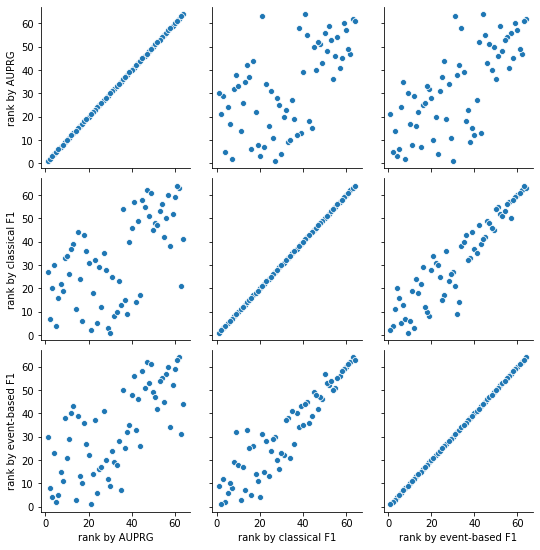

In [60]:
def correlation_analysis(df):
    df = df.copy()
    df = df.rename(columns={s: f'rank by {s[10:]}' for s in df.columns if s != 'accuracy'})
    g = sns.pairplot(df, diag_kind=None)
    plt.savefig('./images/azure/experiments_failure_prediction_azure_correlation.pdf', bbox_inches='tight')
    plt.show()

correlation_analysis(cv_results[scorer_rank_columns])

# Candidate Models Comparison

In [61]:
df = (
    cv_results
    .copy()
    .loc[lambda df: df[scorer_rank_columns].min(axis=1).eq(1),
         [*scorer_rank_columns, *param_cols, *scorer_columns]]
    .reset_index(drop=True)
)
df[scorer_columns] = df[scorer_columns].astype(float).round(10)
df = df.rename(columns={s: f'rank by {s.upper()[10:]}' for s in scorer_rank_columns})
df = df.rename(columns={s: f'{s.upper()[10:]}' for s in scorer_columns})
df = df.T
df.columns = list(string.ascii_uppercase[:df.columns.shape[0]])
df.to_latex('./images/azure/candidate_models.tex')
display(df)

candidate_models_parameters = df

,A,B,C
rank by AUPRG,1,30,21
rank by CLASSICAL F1,27,1,2
rank by EVENT-BASED F1,30,9,1
param_smoothing_window,1,1,1
param_estimator__subsample,0.9,0.9,0.8
param_estimator__n_estimators,256,256,64
param_estimator__min_child_weight,1,1,4
param_estimator__max_depth,6,4,5
param_estimator__learning_rate,0.1,0.2,0.2
param_estimator__colsample_bytree,1,0.9,0.7


## Train the Candidate Models on Full Training Set

In [62]:
model_ids = ['AUPRG', 'event-based F1', 'classical F1']

In [63]:
candidate_models = []
# for i in range(len(selected_models_parameters.columns)):
for i in range(len(candidate_models_parameters.columns)):
    params = candidate_models_parameters.T[param_cols]
    params.columns = params.columns.str[6:]
    params = params.iloc[i].to_dict()
    print(params)
    model = PredictiveMaintenanceModel(
        estimator=XGBClassifier(n_jobs=N_JOBS, random_state=1),
        artificial_window=monitoring_time
    )
    model.set_params(**params)
    model.fit(X_train, y_train)
    candidate_models.append(model)
candidate_models

{'smoothing_window': 1, 'estimator__subsample': 0.9, 'estimator__n_estimators': 256, 'estimator__min_child_weight': 1, 'estimator__max_depth': 6, 'estimator__learning_rate': 0.1, 'estimator__colsample_bytree': 1, 'estimator__booster': 'gbtree'}
{'smoothing_window': 1, 'estimator__subsample': 0.9, 'estimator__n_estimators': 256, 'estimator__min_child_weight': 1, 'estimator__max_depth': 4, 'estimator__learning_rate': 0.2, 'estimator__colsample_bytree': 0.9, 'estimator__booster': 'dart'}
{'smoothing_window': 1, 'estimator__subsample': 0.8, 'estimator__n_estimators': 64, 'estimator__min_child_weight': 4, 'estimator__max_depth': 5, 'estimator__learning_rate': 0.2, 'estimator__colsample_bytree': 0.7, 'estimator__booster': 'dart'}


[PredictiveMaintenanceModel(artificial_window=24, decision_threshold=0.5,
                            estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=1, gamma=0,
                                                    gpu_id=-1,
                                                    importance_type='gain',
                                                    interaction_constraints=None,
                                                    learning_rate=0.1,
                                                    max_delta_step=0,
                                                    max_depth=6,
                                                    min_child_weight=1,
                                                    missing=nan

## Calculate PR Curves

In [64]:
%%time
models_pr_curves = []

alpha = 0.8

for model in candidate_models:

    y_true_series = y_test
    y_score_series = model.predict_proba(X_test)

    thresholds = np.sort(np.unique(np.hstack(y_score_series)))
    # There are lots of predictions with low scores - omit low thresholds
    thresholds = thresholds[thresholds >= 0.01]

    def get_pred_from_score(y_score_series, threshold):
        y_pred_series = [
                np.array(y_score) >= threshold
            for y_score in y_score_series
        ]
        return y_pred_series
          
    def f(threshold):
        y_pred_series = get_pred_from_score(y_score_series, threshold)
        recall = recall_reduced_score(y_true_series, y_pred_series, monitoring_time, warning_time, alpha)
        precision = precision_reduced_score(y_true_series, y_pred_series, monitoring_time, warning_time, alpha)
        return [recall, precision]
    
    pool = multiprocessing.Pool(N_JOBS)

    results = pool.map(f, tqdm(thresholds))
    pool.close()
    recalls, precisions = np.array(results).T
    
    models_pr_curves.append((precisions, recalls, thresholds))

100%|██████████| 3169/3169 [00:16<00:00, 186.92it/s]


CPU times: user 1min 42s, sys: 17.5 s, total: 1min 59s
Wall time: 3min 2s


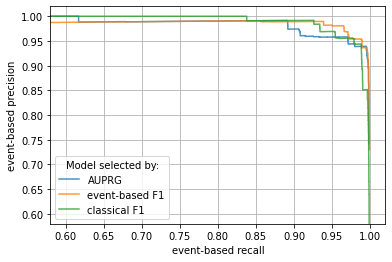

In [65]:
plt.figure(figsize=(6, 4))
for metric, (precisions, recalls, thresholds) in zip(model_ids, models_pr_curves):
    plt.plot(recalls, precisions, label=metric, alpha=0.8)
plt.xlabel('event-based recall')
plt.ylabel('event-based precision')
plt.ylim(0.58, 1.02)
plt.xlim(0.58, 1.02)
plt.legend(title='Model selected by:')
plt.grid()
plt.savefig('./images/azure/experiments_failure_prediction_azure_pr_curves_reduced.pdf', bbox_inches='tight')

In [67]:
%%time
models_classical_pr_curves = []

for model in candidate_models:
    y_true_series = y_test
    y_score_series = model.predict_proba(X_test)
    (precisions, recalls, thresholds) = series_scorer(precision_recall_curve, monitoring_time, warning_time)(y_true_series, y_score_series)
    models_classical_pr_curves.append([precisions, recalls, thresholds])

CPU times: user 1min 17s, sys: 764 ms, total: 1min 18s
Wall time: 3.71 s


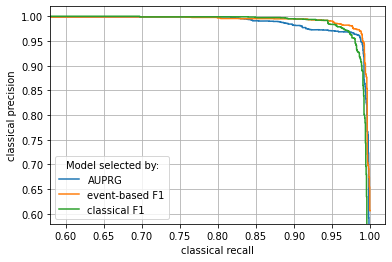

In [68]:
plt.figure(figsize=(6, 4))
for model_id, (precisions, recalls, thresholds) in zip(model_ids, models_classical_pr_curves):
    mask = recalls < 2
    plt.plot(recalls[mask], precisions[mask], label=model_id)
plt.xlabel('classical recall')
plt.ylabel('classical precision')
plt.ylim(0.58, 1.02)
plt.xlim(0.58, 1.02)
plt.grid()
plt.legend(title='Model selected by:')
plt.savefig('./images/azure/experiments_failure_prediction_azure_pr_curves_ts.pdf', bbox_inches='tight')

Model selected by AUPRG


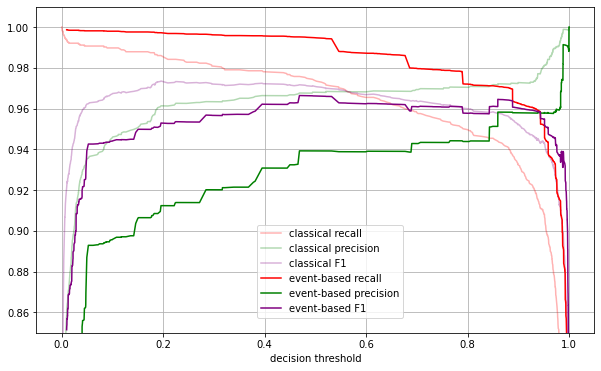

Model selected by event-based F1


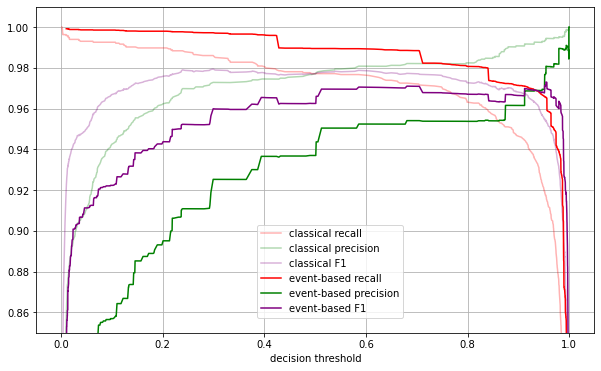

Model selected by classical F1


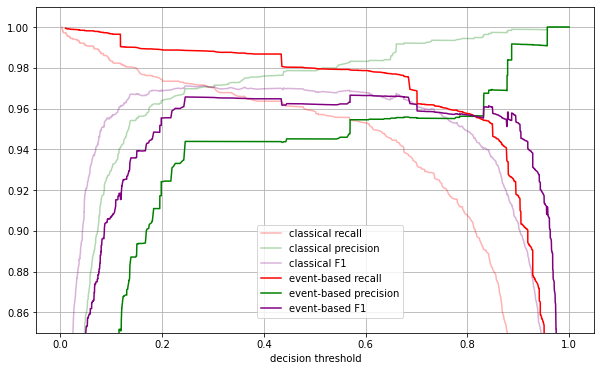

In [69]:
def calc_f1(prec, rec):
    return 2*prec*rec / (prec + rec)

for (model_id,
    (precisions, recalls, thresholds),
    (reduced_precisions, reduced_recalls, reduced_threhsolds),
    (existence_precisions, existence_recalls, existence_threhsolds),
) in list(zip(
        model_ids,
        models_classical_pr_curves,
        models_pr_curves,
        models_existence_pr_curves,
)):
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(np.r_[thresholds, 1], recalls, label='classical recall', color='red', alpha=0.3)
    plt.plot(np.r_[thresholds, 1], precisions, label='classical precision', color='green', alpha=0.3)
    plt.plot(np.r_[thresholds, 1], calc_f1(precisions, recalls), label='classical F1', color='purple', alpha=0.3)
    plt.plot(reduced_threhsolds, reduced_recalls, label='event-based recall', color='red')
    plt.plot(reduced_threhsolds, reduced_precisions, label='event-based precision', color='green')
    plt.plot(reduced_threhsolds, calc_f1(reduced_precisions, reduced_recalls), label='event-based F1', color='purple')
    plt.xlabel('decision threshold')
    print(f'Model selected by {model_id}')
    plt.grid()
    plt.ylim(0.85, 1.01)
    
    ax.figure.legend(loc='upper left', bbox_to_anchor=(0.35, 0.35))
    plt.savefig(f'./images/azure/experiments_failure_prediction_azure_multicurve_{model_id}.pdf', bbox_inches='tight')
    plt.show()